Demonstrate the idea of using the physical model to compensate for areas where we dont have much data, which could be because of data acquisition causing a bottleneck (so data is collected where we expect large variations) or just due to missing data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from gn_model import GN_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [3]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

Play around with the amount of data

In [4]:
down_sample_factor = 3
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [5]:
len(pch)

23

In [51]:
pch[0]

-5.0

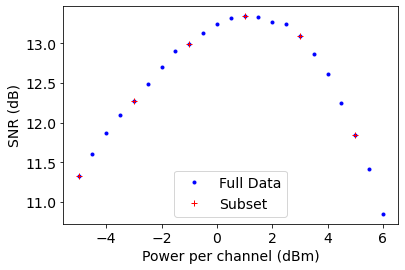

In [6]:
snr_sub = np.copy(snr)[::4]
pch_sub = np.copy(pch)[::4]
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

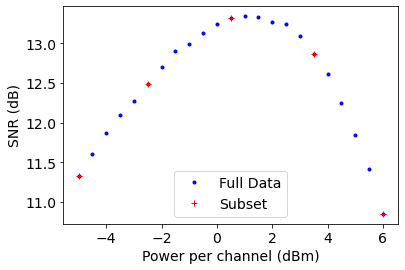

In [10]:
snr_sub = np.array([snr[0], snr[5], snr[11], snr[17], snr[-1]])
pch_sub = np.array([pch[0], pch[5], pch[11], pch[17], pch[-1]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans, TRx back to back SNR [dB] 

In [25]:
#phys_model = GN_model(100, 1550, 1, 0.78, 18, 0.18, 35, 40.2, 50, 5.5, 10, 16.5)
phys_model = GN_model(100, 1550, 1, 0.78, 18, 0.18, 35, 40.2, 50, 4.3, 10, 16)
#phys_model = GN_model(100, 1550, 1, 0.78, 18, 0.174, 35, 40.2, 50, 5.2, 10, 16)

According to Javier, the measurements of Pch may not be reliable and we may need to shift them in order to obtain agreement with the GN model. We do this by calculating the input power per channel that corresponds to peak SNR in the GN model and shifting the peak of measured data to line up with this prediction.

In [28]:
np.random.seed(2)
pch_gn = np.linspace(pch[0], pch[-1], 100)
emp_pk = 1.1
pch_sub_shifted = pch_sub - (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
pch_shifted = pch - (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
pch_gn_example = np.linspace(pch_shifted[0], pch_shifted[-1], 13)
snr_phys_example = (phys_model.predict_snr(pch_gn_example) + np.random.normal(0, 0.03, len(pch_gn_example)) ).reshape(-1,1)

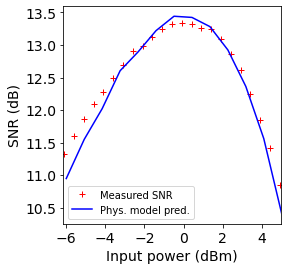

In [60]:
f, ax = plt.subplots()
plt.plot(pch_shifted, snr, 'r+', label='Measured SNR')
plt.plot(pch_gn_example, snr_phys_example, 'b-', label='Phys. model pred.')
plt.xlim([pch_shifted[0]-0.05, pch_shifted[-1]+0.05])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('figures/gn_measurements_comp.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [30]:
num_pts_phys = 20
npp2 = int(num_pts_phys/2)

In [31]:
pch_gn = np.linspace(pch[0], pch[-1], 100)
emp_pk = 1.2
pch_sub_shifted = pch_sub - (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
pch_shifted = pch - (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
pch_gn_shifted = np.linspace(pch_shifted[0], pch_shifted[-1], num_pts_phys)
# a = np.linspace(pch_shifted[1], pch_shifted[4], npp2)
# b = np.linspace(pch_shifted[9], pch_shifted[-2], npp2)
# pch_gn_shifted = np.concatenate((a, b), axis=0)
snr_phys = (phys_model.predict_snr(pch_gn_shifted) + np.random.normal(0, 0.03, len(pch_gn_shifted)) ).reshape(-1,1)
print((emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))]))

1.0888888888888892


In [32]:
# num_points_phys = 20
# #pch_test = np.linspace(pch_fit_shifted[0], pch_fit_shifted[-1], 50).reshape(-1,1) 
# pch_test = np.linspace(pch_shifted[0], pch_shifted[-1], num_points_phys).reshape(-1,1) 
# #snr_phys_test = phys_model.predict_snr(pch_test).reshape(-1,1)
# snr_phys_test = (phys_model.predict_snr(pch_test).reshape(len(pch_test),) + np.random.normal(0, 0.03, len(pch_test))).reshape(-1,1)

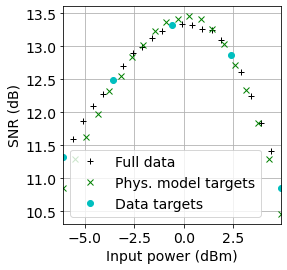

In [33]:
f, ax = plt.subplots()
plt.plot(pch_shifted, snr, 'k+', label='Full data')
plt.plot(pch_gn_shifted, snr_phys, 'gx', label='Phys. model targets')
plt.plot(pch_sub_shifted, snr_sub, 'co', label='Data targets')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
#plt.yticks([10,10.5,11,11.5,12, 12.5, 13, 13.5])
#plt.ylim([12, 13.6])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.grid()
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

Plot the physical model against measured data.

In [34]:
pch_test = np.copy(pch_gn_shifted).reshape(-1,1)
snr_phys_test = np.copy(snr_phys).reshape(-1,1)

In [35]:
pch_sub_shifted = pch_sub_shifted.reshape(-1, 1)  # needed for SK learn input
pch_shifted = pch_shifted.reshape(-1,1)
snr_sub = snr_sub.reshape(-1,1)
kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr_phys.fit_phys(pch_sub_shifted, pch_test, snr_sub, snr_phys_test)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_shifted, return_std=True)
std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
theta_phys = gpr_phys.kernel_.theta
lml_phys = gpr_phys.log_marginal_likelihood()
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [36]:
pch_sub_shifted = pch_sub_shifted.reshape(-1, 1)  # needed for SK learn input
pch_shifted = pch_shifted.reshape(-1, 1)  # needed for SK learn input
kernel_sk =   C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) + W(1, (1e-10,1e5))
gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr.fit(pch_sub_shifted, snr_sub)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk, std_sk = gpr.predict(pch_shifted, return_std=True)
std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
theta = gpr.kernel_.theta
lml = gpr.log_marginal_likelihood()
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

In [37]:
pch_shifted = pch_shifted.reshape(-1, 1)
snr = snr.reshape(-1,1) # needed for SK learn input
kernel_sk =   C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) + W(1, (1e-10,1e5))
gpr_f = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr_f.fit(pch_shifted, snr)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk_f, std_sk_f = gpr_f.predict(pch_shifted, return_std=True)
std_sk_f = np.reshape(std_sk_f,(np.size(std_sk_f), 1)) 
theta_f = gpr_f.kernel_.theta
lml_f = gpr_f.log_marginal_likelihood()
mu_sk_p2_f = mu_sk_f + 2*std_sk_f 
mu_sk_n2_f = mu_sk_f - 2*std_sk_f 

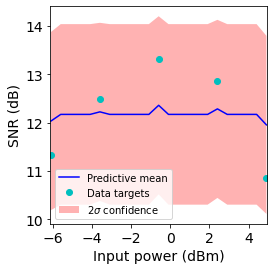

In [59]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'Predictive mean')
#ax.plot(pch_shifted, snr,'k+', label = 'All data')
ax.plot(pch_sub_shifted, snr_sub,'co', label = 'Data targets')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch_shifted[0]-0.05, pch_shifted[-1]+0.05])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(loc=3,prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('figures/comp_standard_gp.pdf', dpi=200,bbox_inches='tight')
plt.show()

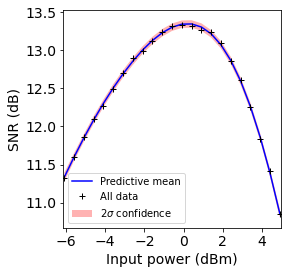

In [62]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk_f, 'b-', label = 'Predictive mean')
ax.plot(pch_shifted, snr,'k+', label = 'All data')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_f,
                            (mu_sk_n2_f)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch_shifted[0]-0.05, pch_shifted[-1]+0.05])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(loc=3,prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('figures/comp_standard_gp_full.pdf', dpi=200,bbox_inches='tight')
plt.show()

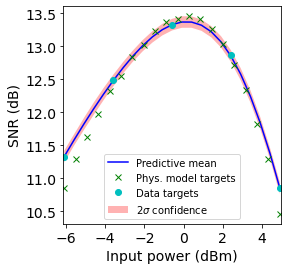

In [63]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk_phys, 'b-', label = 'Predictive mean')
#ax.plot(pch_shifted, snr,'k+', label = 'All data')
ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_sub_shifted, snr_sub,'co', label = 'Data targets')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch_shifted[0]-0.05, pch_shifted[-1]+0.05])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Physics-enhanced GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('figures/comp_gn_enhanced_gp.pdf', dpi=200,bbox_inches='tight')
plt.show()

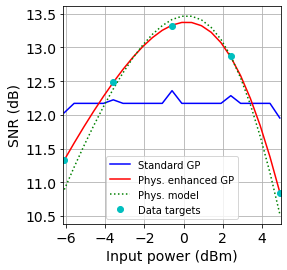

In [64]:
phys_model_snr_plt = phys_model.predict_snr(pch_shifted)
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'Standard GP')
#ax.plot(pch_shifted, mu_sk_f, 'g--', label = 'Standard GP all data')
ax.plot(pch_shifted, mu_sk_phys, 'r-', label = 'Phys. enhanced GP')
#ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_shifted, phys_model_snr_plt, 'g:', label = 'Phys. model')
ax.plot(pch_sub_shifted, snr_sub,'co', label = 'Data targets')
#ax.plot(pch_shifted, snr,'k+', label='Full data set')
plt.xlim([pch_shifted[0]-0.05, pch_shifted[-1]+0.05])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Predictive mean comparison")
plt.legend(prop={'size':10})
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('figures/comp_pred_mean_comp.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/comp_pred_mean_comp_full.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/comp_pred_mean_comp_physmod.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [90]:
max(std_sk)

array([0.242997])

In [22]:
max(std_sk_phys)

array([0.0489435])

Relative change in the predictive std (%):

In [23]:
100*(max(std_sk_phys) - max(std_sk))/max(std_sk)

array([-79.85453156])

Drop in predictive std due to change in interpretation of outlier point!

RMSD of the predictive mean of the model with and without physical models:

In [33]:
np.mean(((mu_sk - mu_sk_phys)**2)**0.5)

0.014609001517925298

Mean relative difference (%):

In [34]:
np.mean(100*(mu_sk - mu_sk_phys)/mu_sk)

0.02051430347209369

In [35]:
np.exp(theta)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + I sigma**2 

array([2.28419688, 1.91170259, 0.1348588 ])

In [36]:
np.exp(theta_phys)

array([7.43645128, 2.76016169, 0.04397225])